In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Мы будем работать с датасетом, в котором лежат данные о португальских школьниках.
В качестве таргета выступает колонка G3 – годовая оценка, принимающее целочисленное значение не выше 20.

In [2]:
df = pd.read_csv('task4.csv') # Считываем датасет
# Разделение категориальных и числовых признаков
binary_cols = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
high_cardinality_cols = ['Mjob', 'Fjob', 'reason', 'guardian']
numeric_cols = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


In [3]:
# Обработка бинарных категориальных признаков
for col in binary_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

# Группировка G3 в категории
bins = [0, 9, 14, 20]
labels = ['низкая', 'средняя', 'высокая']
df.loc[:, 'G3_category'] = pd.cut(df['G3'], bins=bins, labels=labels, include_lowest=True)

# Преобразование G3_category в числовые метки
le_target = LabelEncoder()
df.loc[:, 'G3_category_encoded'] = le_target.fit_transform(df['G3_category'])

# Использование OneHotEncoder вместо TargetEncoder для категориальных признаков
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cols = ohe.fit_transform(df[high_cardinality_cols])
encoded_cols_df = pd.DataFrame(encoded_cols, columns=ohe.get_feature_names_out(high_cardinality_cols), index=df.index)

# Объединяем закодированные категориальные признаки с остальными
df_encoded = pd.concat([df.drop(high_cardinality_cols + ['G3', 'G3_category', 'G3_category_encoded'], axis=1), encoded_cols_df], axis=1)

# Разделение данных
x = df_encoded
y = df['G3_category_encoded']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

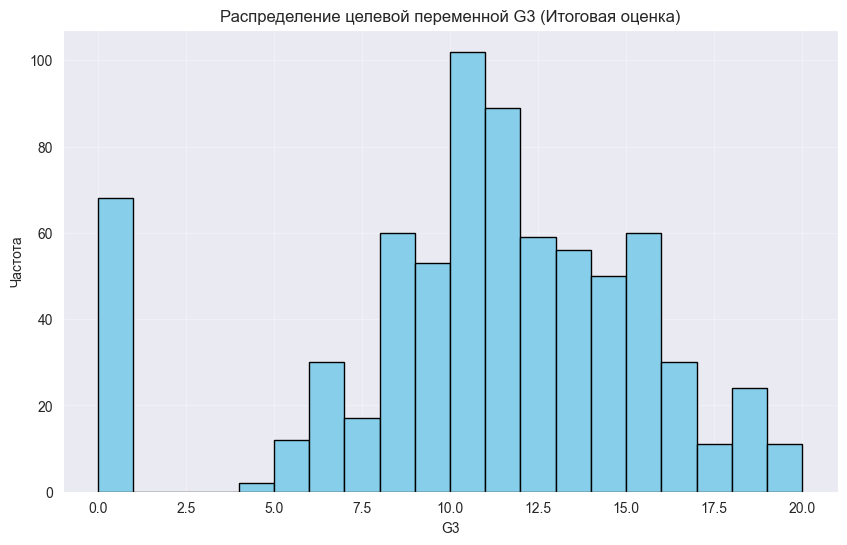

In [4]:
# Визуализация 1: Гистограмма распределения целевой переменной G3
plt.figure(figsize=(10, 6))
plt.hist(df['G3'], bins=20, color='skyblue', edgecolor='black')
plt.title('Распределение целевой переменной G3 (Итоговая оценка)')
plt.xlabel('G3')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)
plt.show()


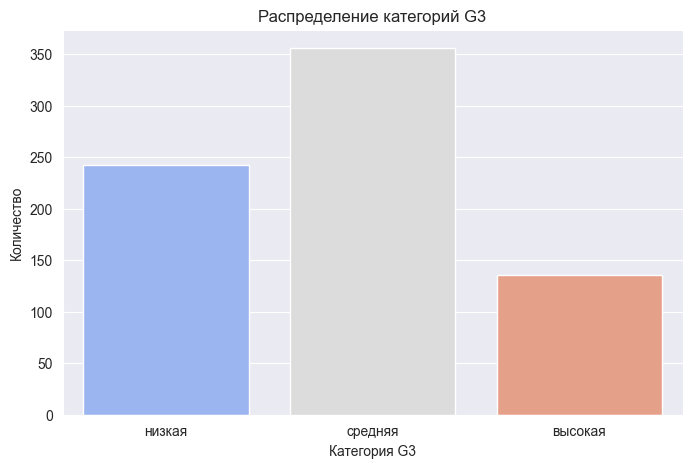

In [5]:
# Визуализация 2: Распределение категорий G3
plt.figure(figsize=(8, 5))
sns.countplot(x='G3_category', data=df, palette='coolwarm', hue=df.G3_category)
plt.title('Распределение категорий G3')
plt.xlabel('Категория G3')
plt.ylabel('Количество')
plt.show()


KNeighborsClassifier — это алгоритм классификации из библиотеки scikit-learn, основанный на методе k-ближайших соседей. Он предсказывает класс объекта, определяя k ближайших точек из обучающей выборки по заданной метрике расстояния (обычно евклидово). Класс выбирается по большинству голосов среди этих соседей. Основные параметры: `n_neighbors` (число соседей), `weights` (веса соседей: 'uniform' или 'distance') и `metric` (метрика расстояния). Алгоритм прост в использовании, но чувствителен к шуму и масштабу признаков, поэтому требует нормализации данных.


In [6]:
# GridSearchCV для поиска лучших параметров
param_grid = {
    'n_neighbors': np.arange(3, 100, 1),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  # Манхэттенская и Евклидова метрики
    'leaf_size': np.arange(10, 250, 10)
}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Вывод лучших параметров и точности
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая точность на кросс-валидации:", grid_search.best_score_)

# Обучение модели с лучшими параметрами
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(x_train, y_train)
y_pred = best_knn.predict(x_test)

# Оценка модели
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Точность на тестовом наборе: {accuracy}")


Лучшие параметры: {'leaf_size': np.int64(10), 'n_neighbors': np.int64(32), 'p': 2, 'weights': 'distance'}
Лучшая точность на кросс-валидации: 0.859090909090909
Точность на тестовом наборе: 0.9594594594594594


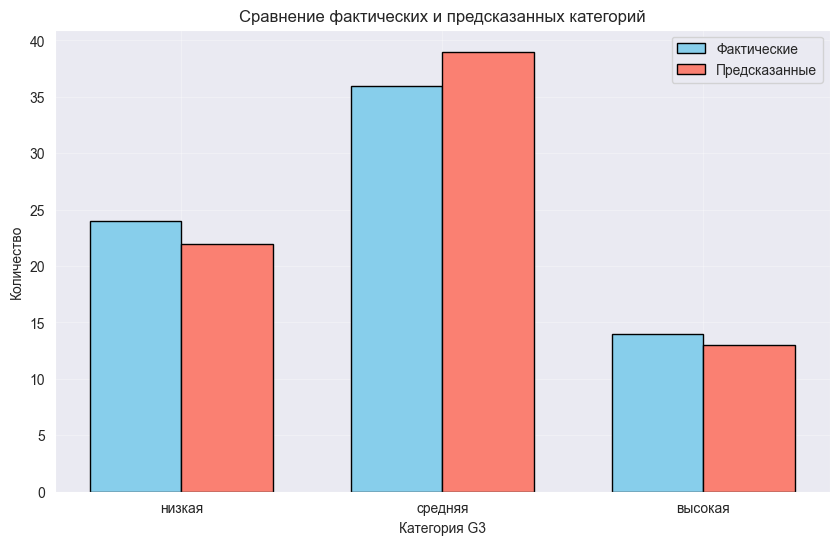

In [7]:
# Визуализация 3: Сравнение предсказанных и фактических категорий
y_test_labels = le_target.inverse_transform(y_test)
y_pred_labels = le_target.inverse_transform(y_pred)

# Подсчет количества каждой категории
test_counts = pd.Series(y_test_labels).value_counts().reindex(['низкая', 'средняя', 'высокая'], fill_value=0)
pred_counts = pd.Series(y_pred_labels).value_counts().reindex(['низкая', 'средняя', 'высокая'], fill_value=0)

# Создание бар-графика
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(labels))

plt.bar(index, test_counts, bar_width, label='Фактические', color='skyblue', edgecolor='black')
plt.bar(index + bar_width, pred_counts, bar_width, label='Предсказанные', color='salmon', edgecolor='black')

plt.xlabel('Категория G3')
plt.ylabel('Количество')
plt.title('Сравнение фактических и предсказанных категорий')
plt.xticks(index + bar_width / 2, ['низкая', 'средняя', 'высокая'])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

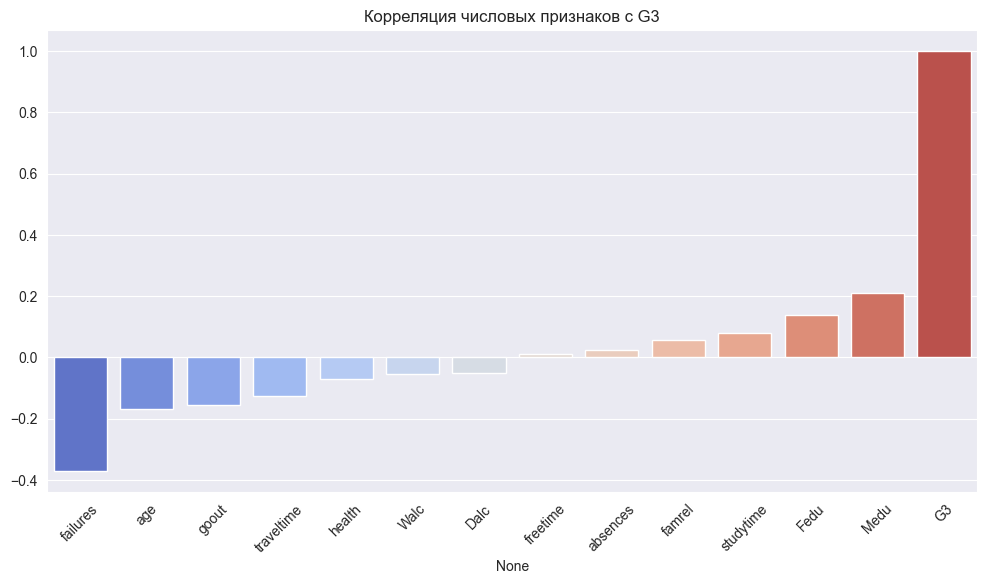

In [8]:
# Визуализация 4: Корреляция числовых признаков с G3
plt.figure(figsize=(12, 6))
correlations = df[numeric_cols + ['G3']].corr()['G3'].sort_values()
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm', hue=correlations.index)
plt.title('Корреляция числовых признаков с G3')
plt.xticks(rotation=45)
plt.show()